In [1]:
import torch

# Loading CHEMBL dataset

In [ ]:
import os
import logging
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import SDWriter
from concurrent.futures import ThreadPoolExecutor, as_completed

# Set up logging to a file
log_file_path = '/rds/user/gtj21/hpc-work/designing-new-molecules/logs'
os.makedirs(os.path.dirname(log_file_path), exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file_path),
        logging.StreamHandler()  # To keep logging to console as well
    ]
)

logger = logging.getLogger(__name__)

# Initialize ChEMBL molecule client
molecule = new_client.molecule

# Define the query to fetch molecules with relevant properties
molecules = molecule.filter(molecule_properties__isnull=False, molecule_type='Small molecule').only(['molecule_chembl_id', 'molecule_structures', 'molecule_properties'])

# Function to process each molecule
def process_molecule(mol):
    try:
        chembl_id = mol['molecule_chembl_id']
        smiles = mol['molecule_structures'].get('canonical_smiles', "")
        molfile = mol['molecule_structures'].get('molfile', "")
        properties = mol['molecule_properties'] if mol['molecule_properties'] else {}
        mol_wt = properties.get('full_mwt')
        logp = properties.get('alogp')
        qed = properties.get('qed_weighted')
        
        # Create RDKit molecule object
        rdkit_mol = Chem.MolFromMolBlock(molfile)
        if rdkit_mol:
            rdkit_mol.SetProp('ChEMBL_ID', chembl_id)
            rdkit_mol.SetProp('SMILES', smiles)
            if mol_wt is not None:
                rdkit_mol.SetProp('Molecular_Weight', str(mol_wt))
            if logp is not None:
                rdkit_mol.SetProp('LogP', str(logp))
            if qed is not None:
                rdkit_mol.SetProp('QED', str(qed))
        
        logger.info(f"Processed molecule {chembl_id}")
        return rdkit_mol
    except Exception as e:
        logger.error(f"Error processing molecule {mol['molecule_chembl_id']}: {e}")
        return None

# Parallel processing of molecules
def process_all_molecules(molecules):
    rdkit_molecules = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(process_molecule, mol) for mol in molecules]
        for future in as_completed(futures):
            result = future.result()
            if result:
                rdkit_molecules.append(result)
    return rdkit_molecules

# Save to SDF
def save_to_sdf(molecules, output_sdf_path):
    os.makedirs(os.path.dirname(output_sdf_path), exist_ok=True)
    writer = SDWriter(output_sdf_path)
    for mol in molecules:
        writer.write(mol)
    writer.close()
    logger.info(f"Saved {len(molecules)} molecules to {output_sdf_path}")

# Main execution
if __name__ == "__main__":
    rdkit_molecules = process_all_molecules(molecules)
    output_sdf_path = '/rds/user/gtj21/hpc-work/designing-new-molecules/data/chembl_molecule_data.sdf'
    save_to_sdf(rdkit_molecules, output_sdf_path)

In [53]:
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import SDWriter
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

# Initialize ChEMBL molecule client
molecule = new_client.molecule

# Define the query to fetch molecules with relevant properties
molecules = molecule.filter(molecule_properties__isnull=False, molecule_type='Small molecule').only(['molecule_chembl_id', 'molecule_structures', 'molecule_properties'])

# Function to process each molecule
def process_molecule(mol):
    chembl_id = mol['molecule_chembl_id']
    smiles = mol['molecule_structures'].get('canonical_smiles', " ")
    molfile = mol['molecule_structures'].get('molfile', " ")
    properties = mol['molecule_properties'] if mol['molecule_properties'] else {}
    mol_wt = properties.get('full_mwt')
    logp = properties.get('alogp')
    qed = properties.get('qed_weighted')
    
    mol_data = {
        'ChEMBL_ID': chembl_id,
        'SMILES': smiles,
        'Molfile': molfile,
        'Molecular_Weight': mol_wt,
        'LogP': logp,
        'QED': qed
    }
    
    # Create RDKit molecule object
    rdkit_mol = Chem.MolFromMolBlock(molfile)
    if rdkit_mol:
        rdkit_mol.SetProp('ChEMBL_ID', chembl_id)
        rdkit_mol.SetProp('SMILES', smiles)
        if mol_wt is not None:
            rdkit_mol.SetProp('Molecular_Weight', str(mol_wt))
        if logp is not None:
            rdkit_mol.SetProp('LogP', str(logp))
        if qed is not None:
            rdkit_mol.SetProp('QED', str(qed))
    
    return rdkit_mol

In [54]:
# Parallel processing of molecules
rdkit_molecules = []
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(process_molecule, mol) for mol in molecules]
    for future in as_completed(futures):
        result = future.result()
        if result:
            rdkit_molecules.append(result)

[17:37:29] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 10 ignored.
[17:37:29] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 10 ignored.
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 65 ignored
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 14 ignored
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 77 ignored
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 97 ignored
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 81 ignored
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 82 ignored
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 85 ignored
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 86 ignored
[17:37:43] Warning: ambiguous ster

In [ ]:
# Save to SDF
output_sdf_path = '/rds/user/gtj21/hpc-work/designing-new-molecules/data/chembl_molecule_data.sdf'  # Update this path as needed
writer = SDWriter(output_sdf_path)
for mol in rdkit_molecules:
    writer.write(mol)
writer.close()

print(f"Saved {len(rdkit_molecules)} molecules to {output_sdf_path}")

# ChemBL dataset exploration

In [40]:
from rdkit import Chem
from rdkit.Chem import PandasTools
import pandas as pd

In [35]:
sdf_file_path = "/rds/user/gtj21/hpc-work/designing-new-molecules/data/chembl_34.sdf"

# Open and read the SDF file
supplier = Chem.SDMolSupplier(sdf_file_path)

[16:13:23] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 14 ignored
[16:13:23] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 27 ignored
[16:13:23] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 40 ignored
[16:13:23] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 44 ignored
[16:13:23] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 20 ignored
[16:13:23] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 17 ignored
[16:13:23] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 28 ignored
[16:13:25] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 65 ignored
[16:13:25] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 14 ignored
[16:13:25] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 77 ignored
[16:13:25] Warning: ambiguous stereochemistry - zero final c

,chembl_id,ID,ROMol
0,CHEMBL153534,CHEMBL153534,
1,CHEMBL440060,CHEMBL440060,
2,CHEMBL440245,CHEMBL440245,
3,CHEMBL440249,CHEMBL440249,
4,CHEMBL405398,CHEMBL405398,
...,...,...,...
2409265,CHEMBL4298696,CHEMBL4298696,
2409266,CHEMBL4298698,CHEMBL4298698,
2409267,CHEMBL4298702,CHEMBL4298702,
2409268,CHEMBL4298703,CHEMBL4298703,

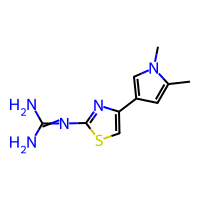
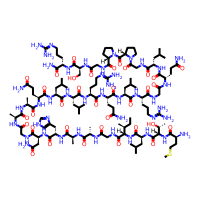
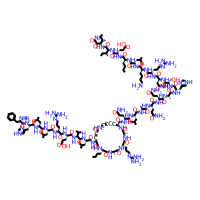
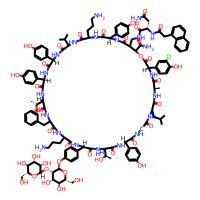
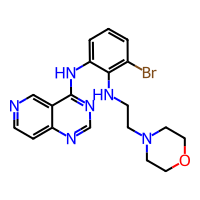
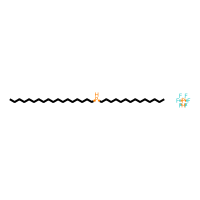
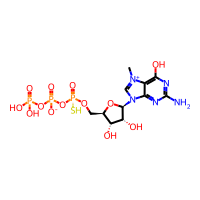
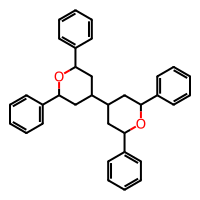
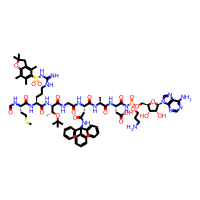
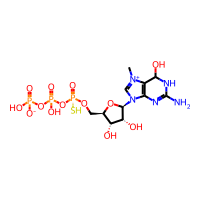

In [36]:
# Read the SDF file into a Pandas DataFrame
df = PandasTools.LoadSDF(sdf_file_path, molColName='ROMol', removeHs=False)
df

# Chembl_molecule_data

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools

# Load the SDF file into a Pandas DataFrame
sdf_file = '/rds/user/gtj21/hpc-work/designing-new-molecules/data/chembl_molecule_data.sdf'
suppl = Chem.SDMolSupplier(sdf_file)

# Create a Pandas DataFrame with molecules
molecules = [mol for mol in suppl if mol is not None]
df = PandasTools.LoadSDF(sdf_file)

[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 12 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 6 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 12 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 13 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 16 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 15 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 1 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 2 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 2 ignored
[09:37:50] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 17 ignored
[09:37:50] Warning: ambiguous stereochemistry - linear bond arrangement - 

In [2]:
df.head()

,ChEMBL_ID,SMILES,Molecular_Weight,LogP,QED,ID,ROMol
0,CHEMBL6329,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,341.75,2.11,0.74,,<rdkit.Chem.rdchem.Mol object at 0x14ff909d54b0>
1,CHEMBL6328,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,332.32,1.33,0.73,,<rdkit.Chem.rdchem.Mol object at 0x14ff909d5570>
2,CHEMBL265667,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,357.80,2.27,0.75,,<rdkit.Chem.rdchem.Mol object at 0x14ff909d5630>
3,CHEMBL6362,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,307.31,1.46,0.74,,<rdkit.Chem.rdchem.Mol object at 0x14ff909d5690>
4,CHEMBL267864,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,341.75,2.11,0.74,,<rdkit.Chem.rdchem.Mol object at 0x14ff909d5750>


In [3]:
df.shape

(1741263, 7)

# Exploartion of Exhaustive search on QED

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

#unimolecular reaction templates (SMARTS strings)
unimolecular_reactions = []

# bimolecular reaction templates (SMARTS strings)
bimolecular_reactions = []

# Create reaction objects from SMARTS strings
uni_reactions = [AllChem.ReactionFromSmarts(smart) for smart in unimolecular_reactions]
bi_reactions = [AllChem.ReactionFromSmarts(smart) for smart in bimolecular_reactions]

In [ ]:
import pandas as pd
from rdkit.Chem import QED

# Function to apply a unimolecular reaction template to a molecule and generate products
def apply_unimolecular_reaction(mol, reaction):
    products = reaction.RunReactants((mol,))
    return [Chem.MolToSmiles(prod[0]) for prod in products if prod]

# Function to apply a bimolecular reaction template to a pair of molecules and generate products
def apply_bimolecular_reaction(mol1, mol2, reaction):
    products = reaction.RunReactants((mol1, mol2))
    return [Chem.MolToSmiles(prod[0]) for prod in products if prod]

# Function to calculate QED score for a molecule
def calculate_qed(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return QED.qed(mol)

# Main function to perform exhaustive search for QED optimization
def optimize_qed_for_dataset(input_file, output_file):
    df = pd.read_csv(input_file)
    results = []

    molecules = [Chem.MolFromSmiles(smiles) for smiles in df['smiles']]

    for mol in molecules:
        if mol is None:
            continue

        best_smiles = Chem.MolToSmiles(mol)
        best_qed = calculate_qed(best_smiles)

        # Apply unimolecular reactions
        for reaction in uni_reactions:
            product_smiles_list = apply_unimolecular_reaction(mol, reaction)
            for product_smiles in product_smiles_list:
                qed_score = calculate_qed(product_smiles)
                if qed_score and qed_score > best_qed:
                    best_qed = qed_score
                    best_smiles = product_smiles

        # Apply bimolecular reactions
        for other_mol in molecules:
            if other_mol is mol:
                continue
            for reaction in bi_reactions:
                product_smiles_list = apply_bimolecular_reaction(mol, other_mol, reaction)
                for product_smiles in product_smiles_list:
                    qed_score = calculate_qed(product_smiles)
                    if qed_score and qed_score > best_qed:
                        best_qed = qed_score
                        best_smiles = product_smiles

        results.append({'original_smiles': Chem.MolToSmiles(mol), 'optimized_smiles': best_smiles, 'qed_score': best_qed})

    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)

In [ ]:
# usage
input_file = 'molecules.csv'
output_file = 'optimized_molecules.csv'
optimize_qed_for_dataset(input_file, output_file)

# Random Search Baseline
1. Load data
2. Generate Molecules
3. Apply Random search algorithm

In [12]:
from rdkit import Chem
from rdkit.Chem import AllChem, QED
import random
import pandas as pd

In [13]:
def parse_template(smarts):
    try:
        if ">>" in smarts:
            reactant_smarts, _ = smarts.split(">>")
        elif ">" in smarts:
            parts = smarts.split('>')
            if len(parts) == 3:
                reactant_smarts, _, _ = parts
            else:
                raise ValueError(f"Invalid SMARTS format: {smarts}")
        else:
            raise ValueError(f"Invalid SMARTS format: {smarts}")
        return reactant_smarts
    except Exception as e:
        print(f"Error parsing SMARTS: {smarts}, {e}")
        return None

def substructure_match(reactant_smiles, template_smarts, use_chirality=False):
    try:
        reactant = Chem.MolFromSmiles(reactant_smiles)
        pattern = Chem.MolFromSmarts(template_smarts)
        if pattern is None:
            return False
        return reactant.HasSubstructMatch(pattern, use_chirality=use_chirality)
    except Exception as e:
        print(f"Error in substructure matching: {e}")
        return False

def apply_template(reactant1, smarts, reactant2=None, type="unimolecular"):
    reactant1_mol = Chem.MolFromSmiles(reactant1)
    if not reactant1_mol:
        return None
    if type == 'unimolecular':
        rxn = AllChem.ReactionFromSmarts(smarts)
        products = rxn.RunReactants(reactant1_mol)
    elif type == 'bimolecular' and reactant2:
        reactant2_mol = Chem.MolFromSmiles(reactant2)
        if not reactant2_mol:
            return None
        rxn = AllChem.ReactionFromSmarts(smarts)
        products = rxn.RunReactants((reactant1_mol, reactant2_mol))
    else:
        return None
    
    if products:
        return [Chem.MolToSmiles(product[0]) for product in products if product]
    return None

def compute_qed(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return QED.qed(mol)
        return None
    except Exception as e:
        print(f"Error computing QED: {e}")
        return None

In [14]:
def random_search(reactants, templates, max_steps=5, max_reactions=10):
    results = []
    total_reactions = 0

    while total_reactions < max_reactions:
        initial_reactant = random.choice(reactants)
        current_reactant = initial_reactant
        sequence = [{'step': 0, 'reactant': initial_reactant, 'template': None, 'product': initial_reactant, 'qed': compute_qed(initial_reactant)}]
        
        for step in range(1, max_steps + 1):
            if total_reactions >= max_reactions:
                break
            
            # Get compatible templates
            compatible_templates = []
            for _, template in templates.iterrows():
                template_smarts = parse_template(template.Smarts)
                if template.Type == 'unimolecular':
                    if substructure_match(current_reactant, template_smarts):
                        compatible_templates.append(template)
                    else:
                        continue
                elif template.Type == 'bimolecular':
                    r1_smarts = template_smarts.split('.')[0]
                    r2_smarts = template_smarts.split('.')[-1]
                    if substructure_match(current_reactant, r1_smarts):
                        compatible_templates.append(template)
                    else:
                        continue

            if not compatible_templates:
                break  # No compatible templates found for the current reactant
            
            template = random.choice(compatible_templates)
            template_smarts = parse_template(template.Smarts)

            if template.Type == 'unimolecular':
                products = apply_template(current_reactant, template.Smarts, type='unimolecular')
                if products:
                    best_product = max(products, key=compute_qed)
                    qed_score = compute_qed(best_product)
                    sequence.append({'step': step, 'reactant': current_reactant, 'template': template.Reaction, 'product': best_product, 'qed': qed_score})
                    current_reactant = best_product
                    total_reactions += 1
                else:
                    continue

            elif template.Type == 'bimolecular':
                r1_smarts, r2_smarts = template_smarts.split('.')
                compatible_reactants = [r for r in reactants if substructure_match(r, r2_smarts)]
                
                if not compatible_reactants:
                    continue
                
                second_reactant = random.choice(compatible_reactants)
                products = apply_template(current_reactant, template.Smarts, reactant2=second_reactant, type='bimolecular')
                if products:
                    best_product = max(products, key=compute_qed)
                    qed_score = compute_qed(best_product)
                    sequence.append({'step': step, 'reactant': current_reactant, 'second_reactant': second_reactant, 'template': template.Reaction, 'product': best_product, 'qed': qed_score})
                    current_reactant = best_product
                    total_reactions += 1
        
        results.append(sequence)
    
    return results

In [15]:
r_enamine = random.sample(enamine_df.SMILES.to_list(), 2)

In [16]:
r_enamine

['CC(C)(C)OC(=O)N1CCN(C2(C(=O)O)CCOC2)CC1', 'CCCn1cc(Cl)cn1']

In [ ]:
# Perform Random Search
random_search_results = random_search(r_enamine, rxn_df_copy)

# Exploring reaction templates

In [1]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

In [13]:
rxn_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/rxn_set.txt", delimiter="|", names=["Reaction", "Smarts", "Label"])

In [14]:
rxn_df.head()

,Reaction,Smarts,Label
0,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",DINGOS Reaction
1,Pictet-Gams,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",DINGOS Reaction
2,Pictet-Spengler-6-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",DINGOS Reaction
3,Pictet-Spengler-5-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",DINGOS Reaction
4,Bischler-Indole,"[NH2,NH3+1:8]-[c:5]1[cH:4][c:3][c:2][c:1][c:6]...",DINGOS Reaction


In [15]:
def rxn_type(reaction_template):
    rxn = AllChem.ReactionFromSmarts(reaction_template)
    if rxn.GetNumReactantTemplates() > 1:
        type = "bimolecular"
    else:
        type = "unimolecular"
    return type

In [16]:
rxn_df["Type"] = rxn_df["Smarts"].apply(rxn_type)

In [17]:
rxn_df.drop(columns='Label', inplace=True)

In [18]:
rxn_df["Type"].value_counts()

Type
bimolecular     49
unimolecular    15
Name: count, dtype: int64

In [19]:
rxn_df.head()

,Reaction,Smarts,Type
0,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",unimolecular
1,Pictet-Gams,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",unimolecular
2,Pictet-Spengler-6-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",bimolecular
3,Pictet-Spengler-5-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",bimolecular
4,Bischler-Indole,"[NH2,NH3+1:8]-[c:5]1[cH:4][c:3][c:2][c:1][c:6]...",bimolecular


In [21]:
rxn_df.to_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/rxn_set_processed.txt",
              sep="|",
              columns=["Reaction", "Smarts", "Type"],
              index=False)

In [22]:
reactants_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/enamine_building_blocks.csv")

In [23]:
reactants_df.shape

(150560, 1)

In [24]:
reactants_df.head()

,SMILES
0,CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C...
1,CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc3ccccc3c...
2,CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)...
3,CC#C[C@@H](CC(=O)O)c1ccc(OCc2cccc(-c3ccc(C(F)(...
4,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...


In [25]:
import random
random_val_set= random.sample(list(reactants_df["SMILES"]), 2000)

In [26]:
len(random_val_set)

2000

In [41]:
# Read the SDF file into a Pandas DataFrame
df = PandasTools.LoadSDF('/rds/user/gtj21/hpc-work/designing-new-molecules/data/chembl_molecule_data.sdf')

[21:39:10] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 12 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 6 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 12 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 13 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 16 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 15 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 1 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 2 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 2 ignored
[21:39:17] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 17 ignored
[21:39:17] Warning: ambiguous stereochemistry - linear bond arrangement - 

In [47]:
df.head()

,ChEMBL_ID,SMILES,Molecular_Weight,LogP,QED,ID,ROMol
0,CHEMBL6329,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,341.75,2.11,0.74,,<rdkit.Chem.rdchem.Mol object at 0x149cf84a53f0>
1,CHEMBL6328,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,332.32,1.33,0.73,,<rdkit.Chem.rdchem.Mol object at 0x149cf8369150>
2,CHEMBL265667,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,357.80,2.27,0.75,,<rdkit.Chem.rdchem.Mol object at 0x149cf8369270>
3,CHEMBL6362,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,307.31,1.46,0.74,,<rdkit.Chem.rdchem.Mol object at 0x149cf83692d0>
4,CHEMBL267864,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,341.75,2.11,0.74,,<rdkit.Chem.rdchem.Mol object at 0x149cf8369390>


# Data exploration of Enamine building blocks and Reaction Template

In [3]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

In [4]:
enamine_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/enamine_building_blocks.csv")
rxn_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/rxn_set_processed.txt", delimiter="|")

In [5]:
enamine_df.head()

,SMILES
0,CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C...
1,CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc3ccccc3c...
2,CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)...
3,CC#C[C@@H](CC(=O)O)c1ccc(OCc2cccc(-c3ccc(C(F)(...
4,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...


In [6]:
enamine_df.describe()

,SMILES
count,150560
unique,150560
top,CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C...
freq,1


In [7]:
rxn_df.head()

,Reaction,Smarts,Type
0,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",unimolecular
1,Pictet-Gams,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",unimolecular
2,Pictet-Spengler-6-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",bimolecular
3,Pictet-Spengler-5-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",bimolecular
4,Bischler-Indole,"[NH2,NH3+1:8]-[c:5]1[cH:4][c:3][c:2][c:1][c:6]...",bimolecular


In [8]:
rxn_df.describe()

,Reaction,Smarts,Type
count,64,64,64
unique,64,64,2
top,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",bimolecular
freq,1,1,49


In [9]:
count = 0
index = []
temp =[]
for i, template in rxn_df.iterrows():
    if ">>" in template.Smarts:
        continue
    elif ">" in template.Smarts:
        count += 1
        index.append(i)
        temp.append(template)
    else:
        pass

In [10]:
rxn_df_copy = rxn_df.drop(index = index)

In [11]:
rxn_df_copy.describe()

,Reaction,Smarts,Type
count,60,60,60
unique,60,60,2
top,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",bimolecular
freq,1,1,46


## Reactants and Tempalte Matching: Pref-filtering

In [10]:
def parse_template(smarts):
    try:
        if ">>" in smarts:
            reactant_smarts, _= smarts.split(">>")
        elif ">" in smarts:
            parts = smarts.split('>')
            if len(parts) == 3:
                reactant_smarts, _, _ = parts
            else:
                raise ValueError(f"Invalid SMARTS format: {smarts}")
        else:
            raise ValueError(f"Invalid SMARTS format: {smarts}")
        return reactant_smarts
    except Exception as e:
            print(f"Error parsing SMARTS: {smarts}, {e}")
            return None, None

def substructure_match(reactant, smarts, use_chirality=False):
    try:
        reactant = Chem.MolFromSmiles(reactant)
        pattern = Chem.MolFromSmarts(smarts)
        if pattern is None:
            return False
        return reactant.HasSubstructMatch(pattern, useChirality=use_chirality)
    except Exception as e:
        print(f"Error in substructure matching: {e}")
        return False   

In [8]:
parse_template(rxn_df["Smarts"][2])

'[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)),C$([CH2](N)(C)):8]-[C$(C(c)(C)(C)(C)),C$([CH](c)(C)(C)),C$([CH2](c)(C)):7]-[c:6]1[c:1][c:2][c:3][c:4][cH:5]1.[CH:10](-[CX4:12])=[O:11]'

In [46]:
substructure_match(enamine_df.SMILES[9], '[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)),C$([CH2](N)(C)):8]-[C$(C(c)(C)(C)(C)),C$([CH](c)(C)(C)),C$([CH2](c)(C)):7]-[c:6]1[c:1][c:2][c:3][c:4][cH:5]1')

False

In [30]:
def pre_filter_unimolecular(reactants, template):
    return [r for r in reactants if substructure_match(r, template)]

def pre_filter_bimolecular_first(reactants, template):
    # Assumes the first reactant in the SMARTS pattern is denoted by [R1]
    first_reactant_smarts = template.split('.')[0]
    return [r for r in reactants if substructure_match(r, first_reactant_smarts)]

def pre_filter_bimolecular_second(reactants, template):
    # Assumes the second reactant in the SMARTS pattern is denoted by [R2]
    second_reactant_smarts = template.split('.')[-1]
    return [r for r in reactants if substructure_match(r, second_reactant_smarts)]

In [ ]:
def analyse_compatibility(reactants, templates, use_chirality=False):
    reactants = reactants.SMILES
    compatibility_results = []
    
    for _, template in templates.iterrows():
        if template.Type == "unimolecular":
            smarts = parse_template(template.Smarts)
            filtered_reactants = pre_filter_unimolecular(reactants, smarts)
            for reactant in filtered_reactants:
                compatibility_results.append((smarts, reactant))
        elif template.Type == "bimolecular":
            smarts = parse_template(template.Smarts)
            first_reactants = pre_filter_bimolecular_first(reactants, smarts)
            second_reactants = pre_filter_bimolecular_second(reactants, smarts)
            for reactant1 in first_reactants:
                for reactant2 in second_reactants:
                    compatibility_results.append((smarts, reactant1, reactant2))
    return compatibility_results

In [58]:
def analyse_compatibility(reactants, templates, use_chirality=False):
    reactants = reactants.SMILES
    unimolecular_counts = []
    bimolecular_counts = []
    
    for _, template in templates.iterrows():
        if template.Type == "unimolecular":
            smarts = parse_template(template.Smarts)
            count = 0
            for r in reactants:
                if substructure_match(r, smarts):
                    count += 1
            unimolecular_counts.append((template.Reaction, count))
            pass
        elif template.Type == "bimolecular":
            smarts = parse_template(template.Smarts)
            # Assumes the first and second reactant in the SMARTS pattern are denoted by [r_1] and [r_2] respectively
            r_1_smarts = smarts.split(".")[0]
            r_2_smarts = smarts.split(".")[-1]
            count_1 = 0
            count_2 = 0
            for r in reactants:
                if substructure_match(r, r_1_smarts):
                    count_1 += 1
                if substructure_match(r, r_2_smarts):
                    count_2 += 1

            bimolecular_counts.append((template.Reaction, count_1, count_2))

    return unimolecular_counts, bimolecular_counts

In [60]:
unimolecular_counts, bimolecular_counts = analyse_compatibility(enamine_df, rxn_df)

In [61]:
unimolecular_counts

[('Bischler-Napieralski', 159),
 ('Pictet-Gams', 9),
 ('Aminothiazol_formation', 925),
 ('Chinonlin-2-one_Intramol', 43),
 ('Tetrazol_formation', 3732),
 ('Dieckmann_5-ring', 18),
 ('Dieckmann_6-ring', 13),
 ('FGI_Acyl_chloride', 19838),
 ('FGI_bromination', 20484),
 ('FGI_chlorination', 20484),
 ('FGI_sulfonyl_chloride', 78),
 ('FGA_alpha_bromination', 16329),
 ('FGA_alpha_chlorination', 16329),
 ('FGI_Rosenmund-von_Braun', 20834),
 ('FGI_nitrilation', 16347)]

In [62]:
bimolecular_counts

[('Pictet-Spengler-6-membered-ring', 1254, 976),
 ('Pictet-Spengler-5-membered-ring', 129, 976),
 ('Bischler-Indole', 7409, 150),
 ('Benzimidazol_formation', 19838, 297),
 ('Benzoxazol_formation', 19838, 162),
 ('Benzothiazol_formation', 19838, 41),
 ('Rap-Stoermer', 115, 168),
 ('Niementowski', 5608, 209),
 ('Quinazolinone_formation', 21035, 209),
 ('Tetrahydro-Indole_formation', 21063, 128),
 ('3-nitrile_pyridine', 97, 1),
 ('Triazole_formation', 3732, 586),
 ('Huisgen_1-3_Dipolar_Cycloaddition', 96, 749),
 ('Huisgen_1_3_Dipolar_Cycloaddition_double_bond', 1414, 749),
 ('Diels-Alder', 2576, 30),
 ('Diels-Alder-Alkyne', 1190, 30),
 ('Spiro-piperidine_formation', 272, 114),
 ('Pyrazol_formation', 250, 127),
 ('Phthalazinone', 250, 38),
 ('Paal-Knorr-pyrole_formation', 27, 21063),
 ('Triaryl-imidazol-1_2-diketone', 2388, 10),
 ('Triaryl-imidazol-alpha_hydroxy_ketone', 2388, 4),
 ('Fischer_indole', 3195, 265),
 ('Friedlaender_chinoline_formation', 3195, 49),
 ('Peachmann_coumarine', 4040

In [80]:
unim = pd.DataFrame(unimolecular_counts, columns=['Reaction', 'First Reactants'])

In [81]:
bim = pd.DataFrame(bimolecular_counts, columns=['Reaction', 'First Reactants', 'Second Reactants'])

In [83]:
unim_bim = pd.concat([unim, bim], axis=0).reset_index(drop=True)

In [88]:
pd.merge(rxn_df, unim_bim, on="Reaction").to_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/rxn_count.txt",
                                                 sep="|",
                                                 index=False)

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
rxn_count = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/rxn_count.txt", delimiter="|")

In [108]:
rxn_count.head()

,Reaction,Smarts,Type,First Reactants,Second Reactants
0,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",unimolecular,159,NaN
1,Pictet-Gams,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",unimolecular,9,NaN
2,Pictet-Spengler-6-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",bimolecular,1254,976.0
3,Pictet-Spengler-5-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",bimolecular,129,976.0
4,Bischler-Indole,"[NH2,NH3+1:8]-[c:5]1[cH:4][c:3][c:2][c:1][c:6]...",bimolecular,7409,150.0


In [99]:
a = rxn_count[rxn_df["Type"] == "unimolecular"]

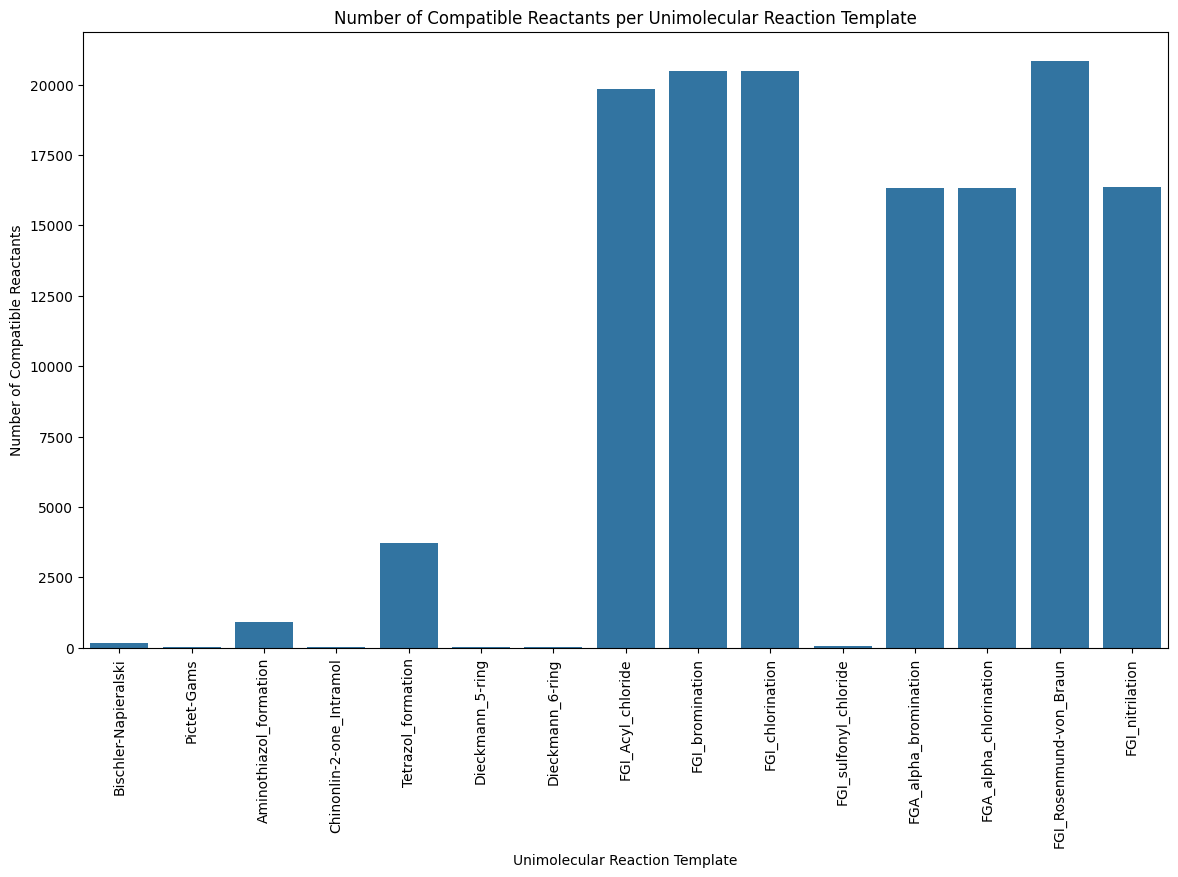

In [101]:
# Plot the results for unimolecular templates
plt.figure(figsize=(14, 8))
sns.barplot(x='Reaction', y='First Reactants', data=a)
plt.title('Number of Compatible Reactants per Unimolecular Reaction Template')
plt.xlabel('Unimolecular Reaction Template')
plt.ylabel('Number of Compatible Reactants')
plt.xticks(rotation=90)
plt.show()

In [104]:
b = rxn_count[rxn_df["Type"] == "bimolecular"]

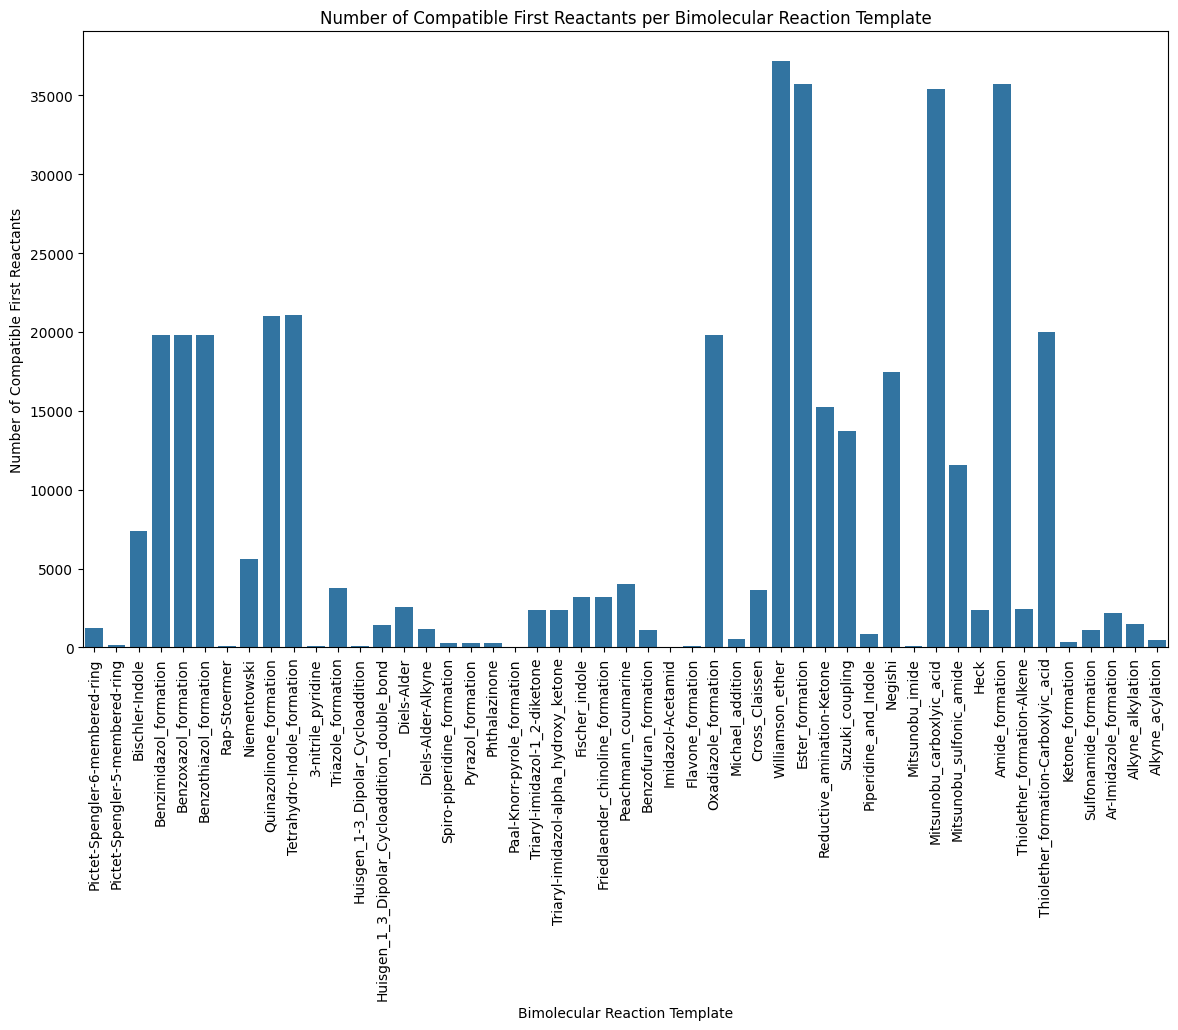

In [106]:
# Plot the results for bimolecular templates (first reactants)
plt.figure(figsize=(14, 8))
sns.barplot(x='Reaction', y='First Reactants', data=b)
plt.title('Number of Compatible First Reactants per Bimolecular Reaction Template')
plt.xlabel('Bimolecular Reaction Template')
plt.ylabel('Number of Compatible First Reactants')
plt.xticks(rotation=90)
plt.show()

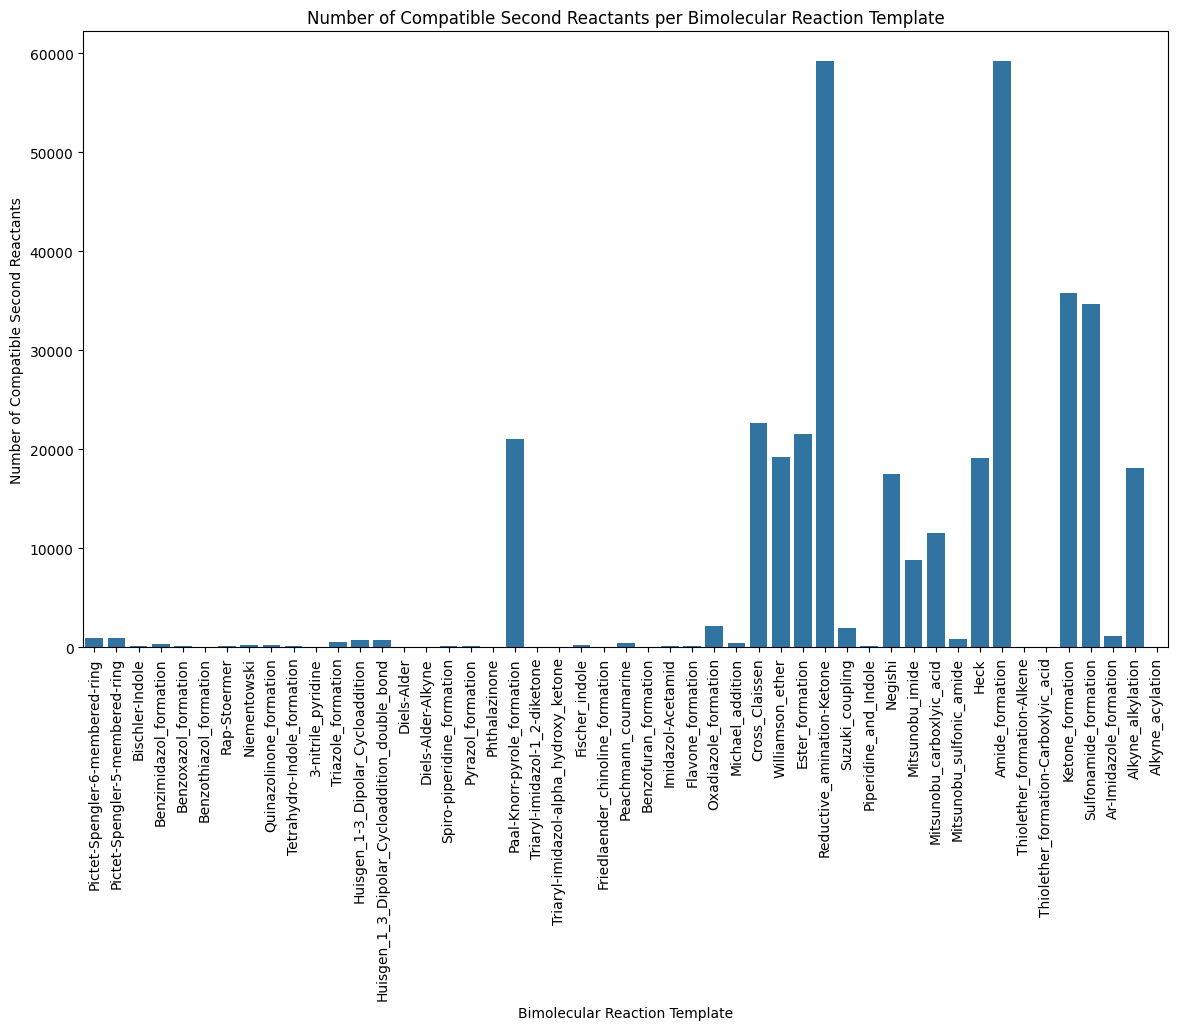

In [107]:
# Plot the results for bimolecular templates (second reactants)
plt.figure(figsize=(14, 8))
sns.barplot(x='Reaction', y='Second Reactants', data=b)
plt.title('Number of Compatible Second Reactants per Bimolecular Reaction Template')
plt.xlabel('Bimolecular Reaction Template')
plt.ylabel('Number of Compatible Second Reactants')
plt.xticks(rotation=90)
plt.show()

In [125]:
def count_matching_templates(reactants, templates):
    reactants = reactants.SMILES
    counts = []
    for reactant in reactants:
        count = 0
        for _, template in templates.iterrows():
            if template.Type == "unimolecular":
                smarts = parse_template(template.Smarts)
                if substructure_match(reactant, smarts):
                    count += 1
                else:
                    continue
            elif template.Type == "bimolecular":
                smarts = parse_template(template.Smarts)
            # Assumes the first and second reactant in the SMARTS pattern are denoted by [r_1] and [r_2] respectively
                r_1_smarts = smarts.split(".")[0]
                r_2_smarts = smarts.split(".")[-1]
                if substructure_match(reactant, r_1_smarts):
                    count += 1
                else:
                    continue
        counts.append((reactant, count))
    return counts

In [128]:
# Count the number of matching templates for each reactant
matching_counts = count_matching_templates(enamine_df, rxn_df)

In [ ]:
matching_counts

# PGFS Implementation playground

In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem

# Define a reaction in SMARTS format
reaction_smarts = '[C:1]=[C:2].[O:3]>>[C:1]-[O:3]-[C:2]'
reaction = AllChem.ReactionFromSmarts(reaction_smarts)

In [2]:
# Get the number of reactant templates
num_reactants = reaction.GetNumReactantTemplates()
print(f'Number of reactant templates: {num_reactants}')

Number of reactant templates: 2


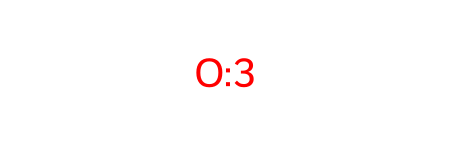

In [5]:
reaction.GetReactantTemplate(1)

In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# Define a list of molecular descriptors
descriptor_names = [
    'MaxEStateIndex', 'MinEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'FpDensityMorgan1', 'BalabanJ',
    'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA7', 'SlogP_VSA3',
    'SlogP_VSA4', 'SlogP_VSA5', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6',
    'FractionCSP3', 'MolLogP', 'Kappa2', 'PEOE_VSA2', 'SMR_VSA5', 'SMR_VSA6', 'EState_VSA7', 'Chi4v', 'SMR_VSA10',
    'SlogP_VSA6', 'EState_VSA8', 'EState_VSA9', 'VSA_EState9'
]

# Initialize the MolecularDescriptorCalculator with the list of descriptors
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

# Example molecule in SMILES format
smiles = "CCO"
mol = Chem.MolFromSmiles(smiles)

# Calculate the descriptors
descriptors = calculator.CalcDescriptors(mol)

# Print the descriptors
for name, value in zip(descriptor_names, descriptors):
    print(f"{name}: {value}")

MaxEStateIndex: 7.569444444444445
MinEStateIndex: 0.25
MinAbsEStateIndex: 0.25
qed: 0.40680796565539457
MolWt: 46.069
FpDensityMorgan1: 2.0
BalabanJ: 1.6329931618554523
PEOE_VSA10: 0.0
PEOE_VSA11: 0.0
PEOE_VSA6: 0.0
PEOE_VSA7: 6.923737199690624
PEOE_VSA8: 6.606881964512918
PEOE_VSA9: 0.0
SMR_VSA7: 0.0
SlogP_VSA3: 0.0
SlogP_VSA4: 0.0
SlogP_VSA5: 6.923737199690624
EState_VSA2: 6.606881964512918
EState_VSA3: 0.0
EState_VSA4: 0.0
EState_VSA5: 0.0
EState_VSA6: 6.923737199690624
FractionCSP3: 1.0
MolLogP: -0.0014000000000000123
Kappa2: 1.96
PEOE_VSA2: 0.0
SMR_VSA5: 6.923737199690624
SMR_VSA6: 6.606881964512918
EState_VSA7: 0.0
Chi4v: 0.0
SMR_VSA10: 0.0
SlogP_VSA6: 0.0
EState_VSA8: 0.0
EState_VSA9: 5.106527394840706
VSA_EState9: 0.0


In [5]:
import pickle
import pandas as pd

# Define the path to your pickle file
pickle_file_path = '/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_precomputed_vectors.pkl'

# Open the pickle file in read-binary mode and load its content
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

In [2]:
if isinstance(data, dict):
    for key, value in data.items():
        print(f"{key}: {value}")

In [3]:
data

[{'CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C)c3ccccc3n1)c(=O)n2C': <rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x1533259072b0>},
 {'CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc3ccccc3c(C)[n+]1[O-])c(=O)n2C': <rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x153325922d30>},
 {'CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)c3ccccc3n1)c(=O)n2C': <rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x15332734a570>},
 {'CC#C[C@@H](CC(=O)O)c1ccc(OCc2cccc(-c3ccc(C(F)(F)F)cc3)c2)cc1': <rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x153325922b70>},
 {'CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[C@@H](c3ccc(N(C)C)cc3)C[C@@]21C': <rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x15334da20830>},
 {'CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[C@@H](c3ccc(NC)cc3)C[C@@]21C': <rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x1533228d3b70>},
 {'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1': <rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x1533228d3db0>},
 {'C#CCC1(C(=O)O)CCN(C(=

In [1]:
import sys
import os

# Add the root directory to the system path
root_dir = os.path.abspath("..")  # Assuming the notebook is one level deep in the 'notebooks' directory
if root_dir not in sys.path:
    sys.path.append(root_dir)

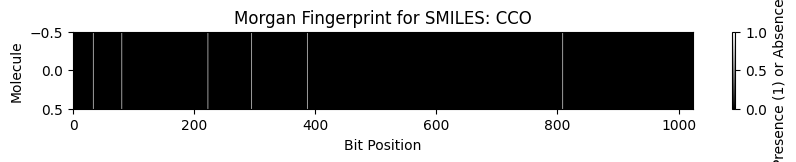

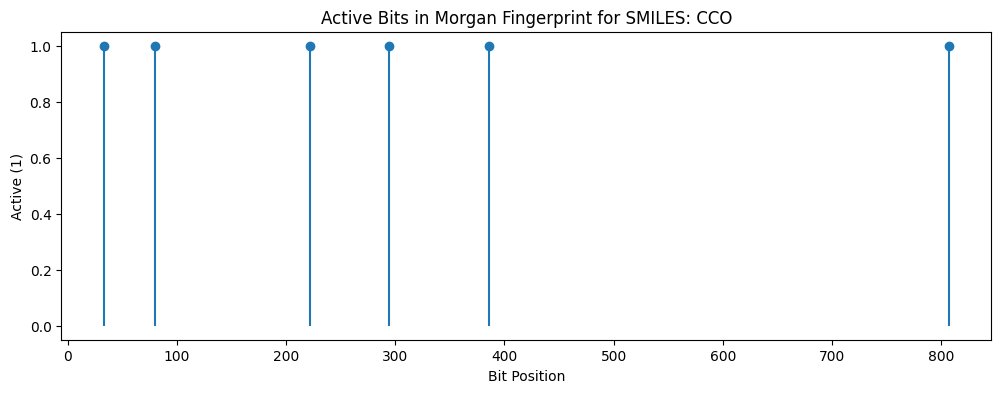

In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import matplotlib.pyplot as plt

# Example SMILES string
smiles = "CCO"

# Convert the SMILES string to an RDKit molecule object
molecule = Chem.MolFromSmiles(smiles)

ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()

# Compute the Morgan fingerprint
fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, radius=2, nBits=1024)

# Convert the fingerprint to a numpy array
fingerprint_array = np.zeros((1, 1024), dtype=int)
AllChem.DataStructs.ConvertToNumpyArray(fingerprint, fingerprint_array[0])

# Plot the fingerprint as a heatmap
plt.figure(figsize=(10, 1))
plt.imshow(fingerprint_array, cmap='gray', aspect='auto')
plt.title("Morgan Fingerprint for SMILES: CCO")
plt.xlabel("Bit Position")
plt.ylabel("Molecule")
plt.colorbar(label='Presence (1) or Absence (0)')
plt.show()

# Plot only the bits that are set to 1
active_bits = np.where(fingerprint_array[0] == 1)[0]

plt.figure(figsize=(12, 4))
plt.stem(active_bits, np.ones_like(active_bits), linefmt='-', markerfmt='o', basefmt=' ')
plt.title("Active Bits in Morgan Fingerprint for SMILES: CCO")
plt.xlabel("Bit Position")
plt.ylabel("Active (1)")
plt.show()


In [12]:
ao.GetBitInfoMap()

{}

In [42]:
from rdkit.Chem import Draw
fpgen = AllChem.GetMorganGenerator(radius=2, fpSize=1024)
ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()
fp = fpgen.GetFingerprint(molecule, additionalOutput=ao)
bi = ao.GetBitInfoMap()

In [43]:
bi[807]

((2, 0),)

In [47]:
mfp2_svg = Draw.DrawMorganBit(molecule, 222, bi, useSVG=True)

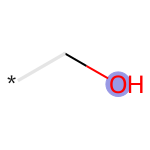

In [48]:
mfp2_svg

In [3]:
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import ConvertToNumpyArray

# Example SMILES strings
smiles_list = ["CCO", "CCN", "CCC"]
targets = [0.9, 0.85, 0.75]

# Convert SMILES to RDKit molecules
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# Function to convert RDKit fingerprint to PyTorch tensor directly
def rdkit_fingerprint_to_tensor(mol, radius=2, nBits=1024):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    arr = torch.zeros(nBits, dtype=torch.float32)
    ConvertToNumpyArray(fp, arr.numpy())
    return arr

# Compute fingerprints and convert to PyTorch tensors
fingerprint_tensors = torch.stack([rdkit_fingerprint_to_tensor(mol) for mol in molecules])
target_tensors = torch.tensor(targets, dtype=torch.float32)

print("Fingerprint Tensors:", fingerprint_tensors)
print("Target Tensors:", target_tensors)


Fingerprint Tensors: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Target Tensors: tensor([0.9000, 0.8500, 0.7500])


In [18]:
fingerprint_tensors.shape

torch.Size([3, 1024])

In [2]:
import pickle

# Load the precomputed fingerprints from the pickle file
with open('/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_fpt_uuid.pkl', 'rb') as f:
    smiles_to_fingerprint = pickle.load(f)

In [4]:
# Check the type and some details of the loaded dictionary
print(type(smiles_to_fingerprint))  # Should be a dictionary
print(len(smiles_to_fingerprint))   # Should be the number of SMILES strings (e.g., 150000)
print(next(iter(smiles_to_fingerprint.items())))  # Print the first item to inspect structure

<class 'dict'>
150560
('3e94f0c1b0624942b280005385722079', {'smiles': 'CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C)c3ccccc3n1)c(=O)n2C', 'vector': tensor([1., 0., 0.,  ..., 0., 0., 0.])})


In [16]:
int(150500 * 0.01329)

2000

In [17]:
import random

def split_data(input_dict, split_ratio=0.01329):
    """
    Split a dictionary into two parts based on a given ratio.

    Args:
        input_dict (dict): The dictionary to split.
        split_ratio (float): The ratio for splitting the dictionary. Defaults to 0.5.

    Returns:
        tuple: Two dictionaries split based on the given ratio.
    """
    keys = list(input_dict.keys())
    random.shuffle(keys)

    split_index = int(len(keys) * split_ratio)
    keys1 = keys[:split_index]
    keys2 = keys[split_index:]

    dict1 = {key: input_dict[key] for key in keys1}
    dict2 = {key: input_dict[key] for key in keys2}

    return dict1, dict2

In [24]:
e_val, e_train = split_data(smiles_to_fingerprint)

In [27]:
print(f"First dictionary:{len(e_train)}")
print(f"Second dictionary: {len(e_val)}")

First dictionary:148560
Second dictionary: 2000


In [23]:
enamine_val= "/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_val.pkl"
enamine_train = "/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_train.pkl"

In [28]:
# Save all vectors to the pickle file
with open(enamine_train, 'wb') as f:
    pickle.dump(e_train, f)

with open(enamine_val, 'wb') as f:
    pickle.dump(e_val, f)

In [34]:
# Load the precomputed fingerprints from the pickle file
with open(enamine_train, 'rb') as f:
    train = pickle.load(f)

In [35]:
len(train)

148560

0

In [9]:
from collections import deque
import torch

# Initialize deque with a maximum length if desired
buffer = deque(maxlen=1000)

# Example results
state = torch.randn(1, 10)
template = torch.randn(1, 34)
action = torch.randn(1, 10)
reward = torch.tensor(0.0).unsqueeze(0)
done = torch.tensor(True).unsqueeze(0)

# Append example results to the buffer
buffer.append((state, template, action))

In [14]:
import random

def sample_buffer(buffer, batch_size):
    # Randomly sample a batch of entries from the buffer
    batch = random.sample(buffer, batch_size)

    # Unzip the batch into separate lists for states, templates, and actions
    states, templates, actions, reward, done = map(torch.cat, zip(*batch)) #lambda x: torch.stack(x, dim=0)
    # Concatenate the lists into tensors with the appropriate batch dimension
    #states = torch.cat(states)
    #templates = torch.cat(templates)
    #actions = torch.cat(actions)

    return states, templates, actions

# Fill the buffer with more example data for demonstration purposes
for _ in range(100):
    state = torch.randn(1, 10)
    template = torch.randn(1, 34)
    action = torch.randn(1, 10)
    reward = torch.tensor((0.0, 4))
    done = torch.tensor(True).unsqueeze(0)
    buffer.append((state, template, action, reward, done))

# Sample from the buffer
batch_size = 4
sampled_states, sampled_templates, sampled_actions = sample_buffer(buffer, batch_size)

print("Sampled States Shape:", sampled_states.shape)        # Output: torch.Size([4, 10])
print("Sampled Templates Shape:", sampled_templates.shape)  # Output: torch.Size([4, 34])
print("Sampled Actions Shape:", sampled_actions.shape)      # Output: torch.Size([4, 10])
print("Sampled Reward shape", reward.shape)
print("Sampled don shape", done.shape)

Sampled States Shape: torch.Size([4, 10])
Sampled Templates Shape: torch.Size([4, 34])
Sampled Actions Shape: torch.Size([4, 10])
Sampled Reward shape torch.Size([2])
Sampled don shape torch.Size([1])


In [20]:
sampled_states[0].shape

torch.Size([1, 10])

In [2]:
import random
import torch

# Select a random subset of 5000 SMILES keys
subset_size = 5000
subset_keys = random.sample(list(smiles_to_fingerprint.keys()), subset_size)
subset_fingerprints = [smiles_to_fingerprint[key] for key in subset_keys]

# Convert the subset to a PyTorch tensor
fingerprint_matrix = torch.tensor(subset_fingerprints, dtype=torch.float32)

print("Binary Fingerprint Matrix Shape:", fingerprint_matrix.shape)

NameError: name 'smiles_to_fingerprint' is not defined

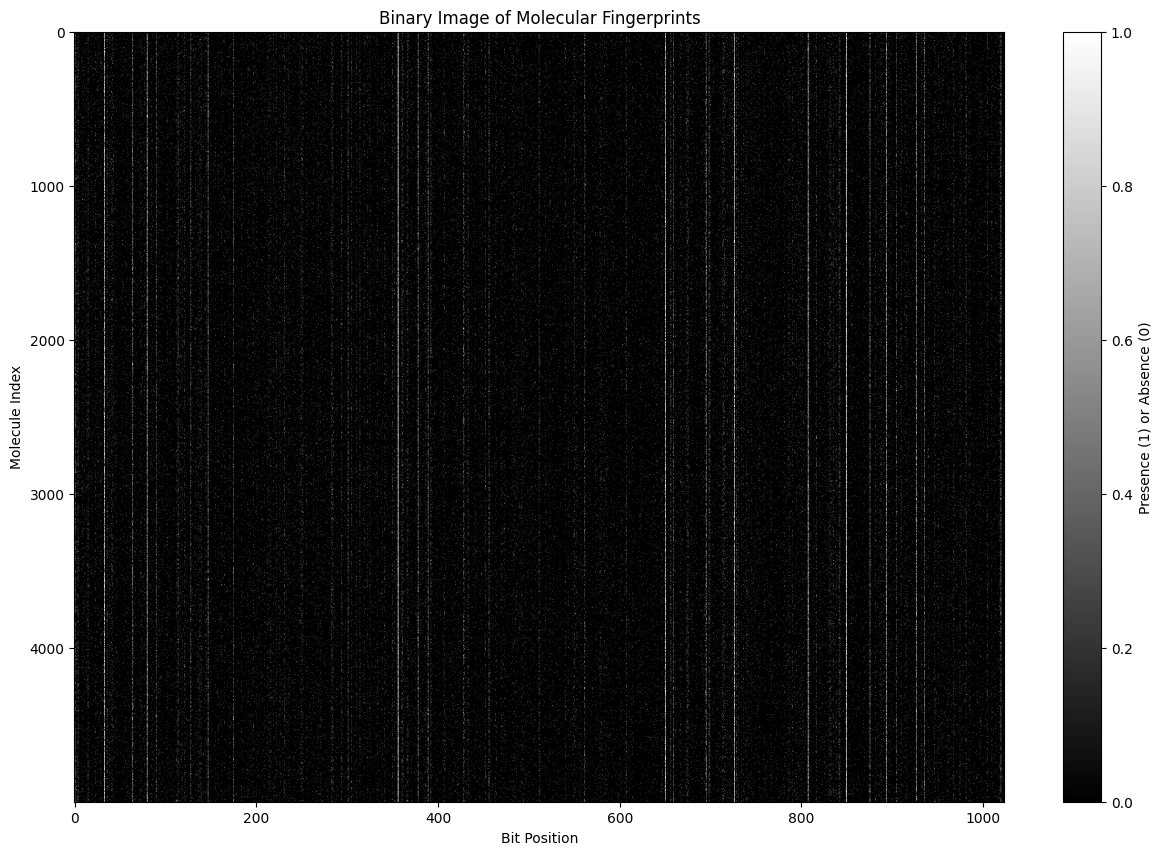

In [40]:
# Plot the binary fingerprint matrix as an image
plt.figure(figsize=(15, 10))
plt.imshow(fingerprint_matrix, cmap='gray', aspect='auto')
plt.title("Binary Image of Molecular Fingerprints")
plt.xlabel("Bit Position")
plt.ylabel("Molecule Index")
plt.colorbar(label='Presence (1) or Absence (0)')
plt.show()

In [ ]:
class ActorModule(nn.Module):
    def __init__(self, state_size, template_size, action_size, representation_action='MolDSet'):
        """
        Initialize the ActorModule with f and pi networks.

        Args:
            state_size (int): Dimension of state input features.
            template_size (int): Dimension of template features.
            action_size (int): Dimension of action features.
            representation_action (str): Type of molecular representation for actions ('ECFP', 'MACCS', 'MolDSet').
        """
        super(ActorModule, self).__init__()
        self.f_network = FNetwork(state_size, template_size)
        self.pi_network = PiNetwork(state_size + template_size, action_size)
        self.representation_action = representation_action

    def forward(self, state, mask, tau):
        """
        Forward pass through the ActorModule.

        Args:
            state (torch.Tensor): State input tensor.
            mask (torch.Tensor): Template mask tensor.
            tau (float): Temperature parameter for Gumbel Softmax.

        Returns:
            tuple: Reaction template T and action a.
        """
        # Predict the best reaction template T
        template = self.f_network(state)
        
        # Apply the mask to T
        masked_template = template * mask
        
        # Apply Gumbel Softmax to T
        gumbel_template = F.gumbel_softmax(masked_template, tau, hard=True)
        
        # Compute the action a
        state_and_template = torch.cat((state, gumbel_template), dim=-1)
        action = self.pi_network(state_and_template)

        # Convert action to the specified representation
        action_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(action))
        action_vector = reactant_to_vector(action_smiles, self.representation_action)
        
        return gumbel_template, torch.tensor(action_vector)

In [1]:
# models/actor.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class FNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Initialize the FNetwork with fully connected layers.

        Args:
            input_dim (int): Dimension of input features (molecular represerntation).
            output_dim (int): Dimension of output features (number of reaction templates).
        
        Task:
            The f network predicts the best reaction template T given the current state s_t (R_t^{(1)}).
        """
        super(FNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, output_dim)

    def forward(self, state):
        """
        Forward pass through the FNetwork.

        Args:
            state (torch.Tensor): Input state tensor (molecular representation).

        Returns:
            torch.Tensor: Output template tensor after passing through the network.
        
        Task:
            The forward method processes the input state to produce the best reaction template T.
        """
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        state = F.relu(self.fc3(state))
        template = torch.tanh(self.fc4(state))
        return template

class PiNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Initialize the PiNetwork with fully connected layers.

        Args:
            input_dim (int): Dimension of input features.
            output_dim (int): Dimension of output features.
        
        Task:
            The pi network computes the action a_t using the best reaction template T and R_t^{(1)}.
        """
        super(PiNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 167)
        self.fc4 = nn.Linear(167, output_dim)

    def forward(self, state_template):
        """
        Forward pass through the PiNetwork.

        Args:
            state_template (torch.Tensor): Concatenated state and template tensor.

        Returns:
            torch.Tensor: Output action tensor after passing through the network.
        
        Task:
            The forward method processes the input state and template to produce the action a_t.
        """
        state_template = F.relu(self.fc1(state_template))
        state_template = F.relu(self.fc2(state_template))
        state_template = F.relu(self.fc3(state_template))
        action = torch.tanh(self.fc4(state_template))
        return action

def actor_procedure(state, f_net, pi_net, T_mask, temperature):
    """
    Actor procedure to select the best reaction template and action.

    Args:
        state (Tensor): Current state (current molecule).
        f_net (nn.Module): Network to predict reaction templates.
        pi_net (nn.Module): Policy network to compute actions.
        T_mask (Tensor): Mask to ensure valid templates.
        temperature (float): Temperature parameter for Gumbel Softmax.

    Returns:
        T (Tensor): Selected reaction template.
        a (Tensor): Selected action.
    """
    # Predict the reaction template using f network
    template = f_net(state)

    # Apply mask to ensure only valid templates
    masked_template  = template * T_mask

    # Use Gumbel Softmax for differentiable sampling
    gumbel_template = F.gumbel_softmax(masked_template, temperature, hard=True)

    # Compute the action using policy network π
    action = pi_net(torch.cat((state, template), dim=-1))

    return gumbel_template, action

In [8]:
# Example usage
input_dim = 1024  # Example input dimension for fingerprints
output_dim = 97  # Example output dimension for reaction templates
action_dim = 1024  # Set action dimension to 1024 to match the feature representation size of reactants
temperature = 1.0  # Initial temperature for Gumbel Softmax

# Initialize networks
f_net = FNetwork(input_dim, output_dim)
pi_net = PiNetwork(input_dim + output_dim, action_dim)

# Example state and mask
state = torch.randn((1, input_dim))  # Example state tensor
T_mask = torch.ones((1, output_dim))  # Example mask tensor (all ones, no invalid templates)

# Run the actor procedure
T, a = actor_procedure(state, f_net, pi_net, T_mask, temperature)

print("Selected reaction template (T):", T)
print("Selected action feature representation (a):", a)

Selected reaction template (T): tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]], grad_fn=<AddBackward0>)
Selected action feature representation (a): tensor([[-0.0215,  0.0465,  0.0163,  ...,  0.0843,  0.1085,  0.0781]],
       grad_fn=<TanhBackward0>)


In [1]:
import pandas as pd

e_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_building_blocks.csv")

In [3]:
e_df.head()

,SMILES
0,CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C...
1,CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc3ccccc3c...
2,CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)...
3,CC#C[C@@H](CC(=O)O)c1ccc(OCc2cccc(-c3ccc(C(F)(...
4,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...


In [7]:
import requests

def check_in_pubchem(smiles):
    base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{}/cids/JSON"
    response = requests.get(base_url.format(smiles))
    if response.status_code == 200 and response.json().get('IdentifierList'):
        return True
    return False

In [10]:
check_in_pubchem(e_df["SMILES"].loc[0])

False

In [11]:
e_df["PubChem"] = e_df["SMILES"].apply(check_in_pubchem)

KeyboardInterrupt: 

In [ ]:
# Flatten the product_sets to get a list of RDKit molecules
            products = [mol for product_set in product_sets for mol in product_set]

            # Sanitize molecules
            sanitized_products = []
            for product in products:
                try:
                    Chem.SanitizeMol(product)
                    sanitized_products.append(product)
                except Chem.SanitizeException:
                    self.logger.error(f"Sanitization failed for molecule: {Chem.MolToSmiles(product)}")
                    continue

            if not sanitized_products:
                return None

            return sanitized_products